# Big Challenge - Diana Hsieh

## Model Description 
This constructs a 2D steady state box model with a single stream reach
#### Dimensions: 
- 50 by 50 by 3 
- dx = dy = 1000 m
- dz = 40m (bottom), 5m (middle), variable (look at excel)  

#### Subsurface Properties: 
- Heterogeneous 
- K = 8.5 m/d bottom layer
- K = 8.5 m/d middle layer in leftmost 20 columns
- K = 0.0001 m/d in z direction in remaining columns
- Porosity = 0.10
- Specific yield = 0.10
- Storage coefficient=0.0001  

#### Stream Properties: 
- Inflow to first reach = 0 m3/d
- Streambed slope = 0.0001 m/m
- Streambed rough = 0.02377
- Streambed width = 20 m
- Streambed K = 0.01 m/day for the rows 0-19, 0.1 for rows 20-25, and 1 for the rest of the stream. 
- Streambed thickness = 1 m
- Stream bottom depth = 7 m

#### Boundary Conditions: 
 - Right boundary is defined head representing a stream that runs 'down' the domain - in the direction of increasing row number.
 - Left boundary is a constant head representing a lake.

# Set up the environment

In [61]:
import flopy
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import flopy.utils.binaryfile as bf

%matplotlib inline

# User inputs

In [62]:
modelname = "bigchallenge_model"
moddir="C:/Users/dnahh/Desktop/GW_Modeling/homework-hsiehdf/Working/mf2005" #Update this to find your modflow application
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

nrow = 50
ncol = 50
dx = 1000
dy = 1000
nlay=3  #3 layers

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# print(type(ztop))
zbot = 0

#dz = (ztop - zbot) / nlay
#Lx = dx*ncol
#Ly = dy*nrow

K_horiz = 8.5    #assign horizontal hydraulic conductivity 
K_vert = 8.5    #assign vertical hydraulic conductivity (along z axis)
ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage
ss[:,:,:] = 0.0001 #Storage coeff
n = 0.1 #porosity
Sy = 0.1 #specific yield
uncnf = 1

## Setting up Layer properties

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 40 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 45 m 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,21:-1] = 0.0001                   # Replace the K in the middle layer with the lower value for 30 R columns

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
#Kh[1,:,21:-1] = 0.0001                    # Horizontal K does not change

nper = 1
steady = [True]

#Create dis object
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)   #Model unit meters (lenuni = 2) and days (itmuni = 4)




C:\Users\dnahh\AppData\Local\Temp\ipykernel_11344\681030314.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage


# Seting up Boundary Conditions

In [63]:
#Create bas object
# Our Boundary Conditions 
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = 0 # whole left side is no flow
ibound[:, :, -1] = -1 # whole right side constant head
ibound[:, 0, :] = 0 # first row (top of domain) is no flow
ibound[:, -1, :] = 0 # last row (bottom of domain) is no flow
for i in range (0,6):
    ibound[0:, i, 0:6-i] = 0
for i in range (0,8):
    ibound[1, i, 0:8-i] = 0
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+1] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
h_right = 70
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value


bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m)

#LPF object
#hk = np.ones((nlay,nrow,ncol), dtype=np.float32)      #defining conductivity in m/d
#vk = np.ones((nlay,nrow,ncol), dtype=np.float32)

# vk = vk/10
# hk[:,0:25,:] = hk[:,0:25,:]*10
# vk = vk*10

lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 


# Rch object
recharge = 4e-5 #m/day
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[:,0:16]= recharge
#rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object

#create  output control object 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#ET
ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[:,:,25:-1] = 1e-5  # ET only on right half of domain
ET_zone[:,22:29,:] = 5e-4  #stream ET

extinction_depth = 1 #extinction depth is the depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation


evt = flopy.modflow.mfevt.ModflowEvt(model=m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 

#print(strt)
#print(ET_zone)
#print(rech_zone)

# Setup the stream! Define STR object

In [64]:
# User inputs:
k_strbott = 1.36 * K_horiz                      #river bottom hydraulic conductivity in f/d
sed_thick = 1                      #thickness of riverbed sediment in f
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
width = 1                           #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0    # m^3/day
Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# str settings
set_icalc = 0                   #1 if the stage is to be calculated based on flow, otherwise specify below
                            # Set icalc = 0 bc stage doesn't change
str_spd1 = []                      #create list to store all river cells for stress period 1
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

# calculated values
cond = k_strbott*(dy)*(dx)/(sed_thick) #river bed conductance in f^2/d
cond_vals = np.ones(nrow)
#cond_vals[0:20] = cond/100
#cond_vals[21:26] = cond/10
#cond_vals[27:-1] = cond


str_stage = Stage_above_datum

#if set_icalc > 0:      #Calculating the stage for graphing using Manning formula
#    str_stage = str_top + ((Flow_into_the_1st_reach*rough)/(const*width*(slope**0.5)))**0.6   
#    print("Calculated stage at inflow =", str_stage)

#Adding str package with only 1 stress period and one segment
strd = {}  
strspd = []
for y in range(ncol):
    str_bott = ztop[24,y]-2  #river bottom is defined as the ztop at row 25 minus 2
    str_top = str_bott+sed_thick #stream top is stream bottom + sed thickness
    add = [0, nrow/2, y, 1, y+1, Flow_into_the_1st_reach, str_stage, cond_vals[y], str_bott, str_top, width, slope, rough]
    strspd.append(add)
strd[0]=strspd   
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

strm = flopy.modflow.mfstr.ModflowStr(m, mxacts=75, nss=1, ntrib=0, ndiv=0,icalc= set_icalc, const=const, ipakcb=53,  istcb2=istcb2, dtype=None,
        stress_period_data=strd, segment_data=str_segd, extension='str') 

#print(cond_vals)



# Plot model grid and boundary conditions

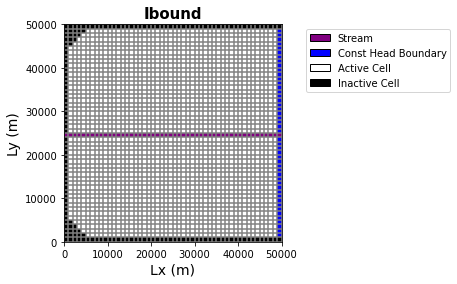

In [65]:
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

# Write MODFLOW input files and run the model

In [66]:
m.write_input()

success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/dnahh/Desktop/GW_Modeling/homework-hsiehdf/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: bigchallenge_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/18 21:26:21

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/18 21:26:21
 Elapsed run time:  0.037 Seconds

  Normal termination of simulation


# Plot stream related results 

[-999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99, -999.99]


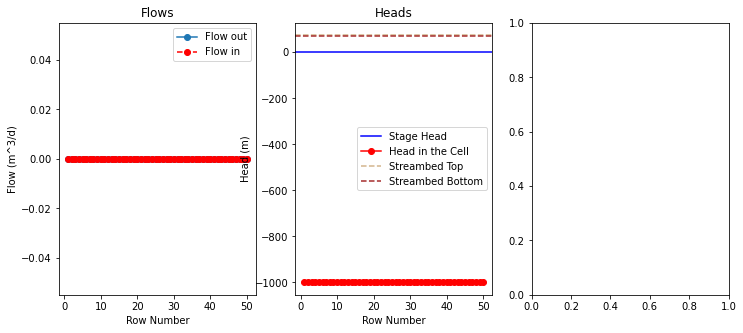

In [67]:
#####################################################################
# Reading budget and head output files
budgobj1 = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
#print(budgobj1.get_unique_record_names())
frf = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
leak = budgobj1.get_data(text='STREAM LEAKAGE', totim=1.0) 

str_outflow = budgobj1.get_data(text='STREAM FLOW OUT', totim=1.0) 
ch_flow = budgobj1.get_data(text='CONSTANT HEAD', totim=1.0) 

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
head = headobj.get_data(totim=1.0)

#####################################################################
#Preparing variables for plotting 
leakage = leak[0]
str_outflow = str_outflow[0]
str_inflow = str_outflow[:nrow-1]
str_inflow = str_inflow['q']
str_inflow = str_inflow.tolist()
str_inflow.insert(0, Flow_into_the_1st_reach) 
reach = np.arange(0,nrow,1) + 1
head_reach=[]
x_str = strspd[0][2]
x_str=int(x_str)
for i in range(nrow):
    head_reach.append(head[0][i][x_str])

#####################################################################
# Plotting reach wise water budget
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
#ax.set_aspect('equal')
ax1.set_title('Flows')
# ax1.plot(reach, leakage['q'], lw=3, label="Leaked to Aquifer", marker='o') 
ax1.plot(reach, str_outflow['q'], label="Flow out", marker='o') 
ax1.plot(reach, str_inflow, color='red', label="Flow in", linestyle='--', marker='o') 
# ax1.axhline(y=0,  color='black', linestyle='--')
ax1.set_xlabel('Row Number')
#ax1.set_xticks(reach)
ax1.set_ylabel('Flow (m^3/d)')
ax1.legend()

#####################################################################
# Plotting reach wise heads
ax2.set_title('Heads')
ax2.axhline(y=str_stage,  color='blue', label="Stage Head")
ax2.plot(reach, head_reach, color='red', label="Head in the Cell", marker='o') 
ax2.axhline(y=str_top,  color='tan', linestyle='--', label="Streambed Top")
ax2.axhline(y=str_bott,  color='brown', linestyle='--', label="Streambed Bottom")
ax2.set_xlabel('Row Number')
#ax2.set_xticks(reach)
ax2.set_ylabel('Head (m)')
ax2.legend()

print (head_reach)

# Plot head distribution

C:\Users\dnahh\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\dnahh\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


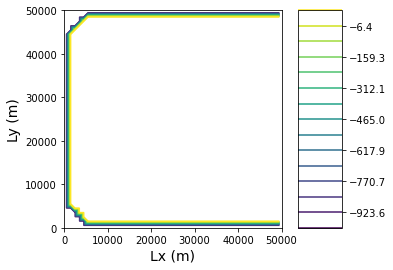

In [68]:
#####################################################################
# Plotting heads and flow arrows
plt.figure() 
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Steady-State Pumping, Flow(f^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)

# Yes Town No Ag

In [69]:
modelname = "bigchallenge_model"
moddir="C:/Users/dnahh/Desktop/GW_Modeling/homework-hsiehdf/Working/mf2005" #Update this to find your modflow application
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

nrow = 50
ncol = 50
dx = 20
dy = 20
nlay=3  #3 layers

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# print(type(ztop))
zbot = 0.

#dz = (ztop - zbot) / nlay
#Lx = dx*ncol
#Ly = dy*nrow

K_horiz = 8.5    #assign horizontal hydraulic conductivity 
K_vert = 8.5    #assign vertical hydraulic conductivity (along z axis)
ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage
ss[:,:,:] = 0.0001 #Storage coeff
n = 0.10 #porosity
Sy = 0.10 #specific yield
uncnf = 1

## Setting up Layer properties

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 40 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 45 m 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,21:-1] = 0.0001                   # Replace the K in the middle layer with the lower value for 30 R columns

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
#Kh[1,:,21:-1] = 0.0001                    # Replace the K in the middle layer with the lower value fpr 30 R columns

nper = 1
steady = [True]

#Create dis object
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)   #Model unit meters (lenuni = 2) and days (itmuni = 4)



C:\Users\dnahh\AppData\Local\Temp\ipykernel_11344\1348838581.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage


In [70]:
#Create bas object
# Our Boundary Conditions 
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = 0 # whole left side is no flow
ibound[:, :, -1] = -1 # whole right side constant head
ibound[:, 0, :] = 0 # first row (top of domain) is no flow
ibound[:, -1, :] = 0 # last row (bottom of domain) is no flow
ibound[0, 0:6, 0:6] = 0 #top L of the triangle
ibound[1, 0:8, 0:8] = 0 #top middle L triangle
ibound[2, 0:10, 0:10] = 0 #top bottom L triangle
ibound[0, 44:50, 0:6] = 0 #bottom top R of the triangle
ibound[1, 42:50, 0:8] = 0 #bottom middle R triangle
ibound[2, 40:50, 0:10] = 0 #bottom bottom R triangle


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
h_right = 70
H_init[:, :, -1] = h_right    #initialize the entire domain to the right head value


bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=1000, iter1=2000, relax = 0.7, damp = 0.7)

#LPF object
hk = np.ones((nlay,nrow,ncol), dtype=np.float32)      #defining conductivity in m/d
vk = np.ones((nlay,nrow,ncol), dtype=np.float32)

# vk = vk/10
# hk[:,0:25,:] = hk[:,0:25,:]*10
# vk = vk*10



lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=hk, 
                               vka=vk, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 


## Well
pumping = -1500 #m3/day  #given
well_xy= [1200, 1400] #xy location of well 
well_row = np.floor((nrow-1)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx-1) #convert the x location to a column
well_loc = (0,well_row,well_col) #Well loc should be layer, row, column
print(well_loc)
print(well_col)

well_1 = [i for i in well_loc] + [pumping]
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {0: [well_1]}
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

# Rch object
recharge = 4e-5 #m/day
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[:,0:16]= recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object

#create  output control object 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#ET
ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[:,:,25:-1] = 1e-5  # ET only on right half of domain
ET_zone[:,22:29,:] = 5e-4  #stream ET

extinction_depth = 1 #extinction depth is the depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation


#evt = flopy.modflow.mfevt.ModflowEvt(model=m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 

#print(strt)
#print(ET_zone)
#print(rech_zone)

(0, -21.0, 59.0)
59.0
Well 1 [layer, row, column, flux]: 
 [0, -21.0, 59.0, -1500]


In [71]:
# User inputs:
k_strbott = 1.36 * K_horiz                      #river bottom hydraulic conductivity in f/d
sed_thick = 1                      #thickness of riverbed sediment in f
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
width = 1                           #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0    # m^3/day
Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# str settings
set_icalc = 0                   #1 if the stage is to be calculated based on flow, otherwise specify below
                            # Set icalc = 0 bc stage doesn't change
str_spd1 = []                      #create list to store all river cells for stress period 1
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

# calculated values
cond = k_strbott*(dy)*(dx)/(sed_thick) #river bed conductance in f^2/d
cond_vals = np.ones(nrow)
#cond_vals[0:20] = cond/100
#cond_vals[21:26] = cond/10
#cond_vals[27:-1] = cond


str_stage = Stage_above_datum

#if set_icalc > 0:      #Calculating the stage for graphing using Manning formula
#    str_stage = str_top + ((Flow_into_the_1st_reach*rough)/(const*width*(slope**0.5)))**0.6   
#    print("Calculated stage at inflow =", str_stage)

#Adding str package with only 1 stress period and one segment
strd = {}  
strspd = []
for y in range(ncol):
    str_bott = ztop[24,y]-2  #river bottom is defined as the ztop at row 25 minus 2
    str_top = str_bott+sed_thick #stream top is stream bottom + sed thickness
    add = [0, nrow/2, y, 1, y+1, Flow_into_the_1st_reach, str_stage, cond_vals[y], str_bott, str_top, width, slope, rough]
    strspd.append(add)
strd[0]=strspd   
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

strm = flopy.modflow.mfstr.ModflowStr(m, mxacts=75, nss=1, ntrib=0, ndiv=0,icalc= set_icalc, const=const, ipakcb=53,  istcb2=istcb2, dtype=None,
        stress_period_data=strd, segment_data=str_segd, extension='str') 

print(cond_vals)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [72]:
m.write_input()

success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/dnahh/Desktop/GW_Modeling/homework-hsiehdf/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: bigchallenge_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/18 21:26:23



Exception: MODFLOW did not terminate normally.